## Technical Challenge: Diffusion Model

What is a diffusion model?

A Diffusion Model is a generative neural network designed to generate new data, typically images. Its operation is based on two processes: a forward process, in which the model adds Gaussian noise to the training data, and a reverse process, in which a neural network is trained to learn how to reverse this degradation, removing the noise to reconstruct a new, clean sample. (ref: [IBM](https://www.ibm.com/br-pt/think/topics/diffusion-models))

In [2]:
# General Libs
from tensorflow import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.src.legacy.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D

In [3]:
# Load the dataset
(X_train, _), (X_test, _) = mnist.load_data()

print('Train: ', X_train.shape)
print('Test: ', X_test.shape)

Train:  (60000, 28, 28)
Test:  (10000, 28, 28)


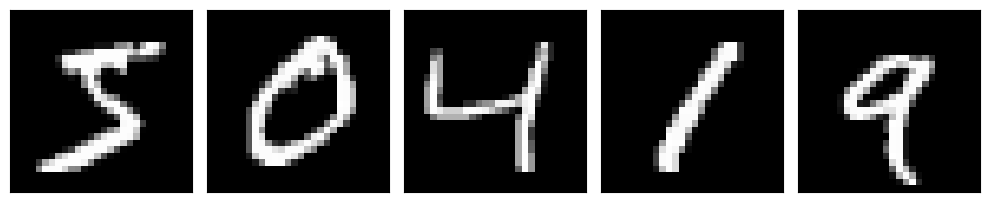

In [4]:
# Plot some images from the dataset
n_imgs = 5
fig, axes = plt.subplots(1, n_imgs, figsize=(10, 3))

for i in range(n_imgs):
  axes[i].imshow(X_train[i], cmap='gray')
  axes[i].set_xticks([])
  axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Basic implementation of the forward process and reverse process concept

In [5]:
# Example: use 5 images from the dataset and normalize
x_samples = []
for i in range(5):
  x_samples.append(X_train[i] / 255.0)

In [6]:
# Foward process (insert random noise into images using the np.random.normal() function)
train_noise = []
sigma = 0.2
for i in range(5):
  noise = np.random.normal(0, sigma, x_samples[i].shape)
  train_noise.append(x_samples[i] + noise)

In [7]:
# function to plot images
def plot_imgs(all_imgs):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(all_imgs[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

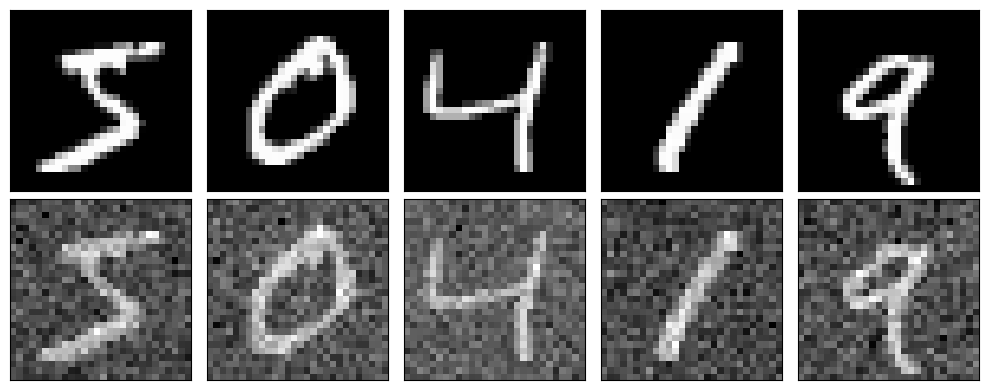

In [8]:
# Plot the comparison of real images and noisy images
all_imgs = x_samples + train_noise
plot_imgs(all_imgs)

In [9]:
# Reverse process (transform noisy images into new clean images, here we subtract the noise inserted in the image to generate new images
noiseless_img = []
sigma = 0.3
for i in range(5):
  noiseless = np.random.normal(0, sigma, train_noise[i].shape)
  noiseless_img.append(train_noise[i] - noiseless)

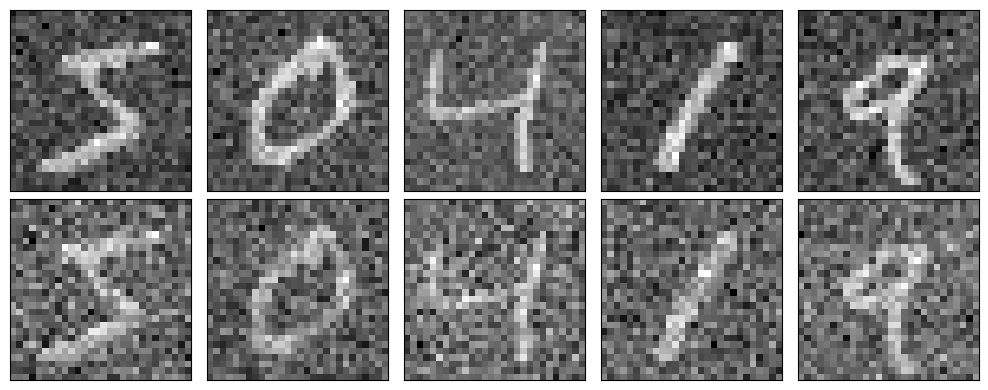

In [10]:
# Plot the comparison of noisy images and the attempt to remove noise from these images
all_imgs = train_noise + noiseless_img
plot_imgs(all_imgs)

But what happened to the images that should have been clean in the reverse process?

Basically, the model isn't removing the noise correctly because it's subtracting random noise without knowing the original noise. To perform this removal properly, the model would need to be trained to understand the noise pattern, identify it, and then generate a clean image. Therefore, the central idea of ​​a diffusion model is to learn and predict the correct noise to generate new data.

### Implemented simple idea of ​​a diffusion model

In [11]:
# Reshape and normalize data
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)) / 255.0
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)) / 255.0

In [12]:
# Function to add noise to images (foward process)
def add_noise(img, sigma=0.4):
    noise = np.random.normal(0, sigma, img.shape)
    imgs_with_noise = np.clip(img + noise, 0.0, 1.0)
    return imgs_with_noise

In [13]:
# Add noise to the data
noisy_X_train = add_noise(X_train)
noisy_X_test = add_noise(X_test)

In [14]:
# Simple model for the reverse process
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1), padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding="same"))
model.add(Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding="same"))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding="same"))

model.compile(optimizer="adam", loss="binary_crossentropy")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,001 (437.50 KB)

 Trainable params: 112,001 (437.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Training the model
model.fit(
    x = noisy_X_train,
    y = X_train,
    epochs = 50,
    batch_size = 128,
    shuffle = True,
    validation_data = (noisy_X_test, X_test)
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.2540 - val_loss: 0.0983
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0973 - val_loss: 0.0933
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0927 - val_loss: 0.0899
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0904 - val_loss: 0.0888
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0889 - val_loss: 0.0874
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0878 - val_loss: 0.0867
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0870 - val_loss: 0.0861
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0864 - val_loss: 0.0856
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0860 - val_loss: 0.0855
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0857 - val_loss: 0.0849
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0851 - val_loss: 0.0847
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━

In [18]:
# save the model
model.save('simple_diffusion_model.keras')